#Base pose planning with OpenRave

**Disclaimer:**  
This is my first attempt at a tutorial using IPython notebooks. This is made all too complicated by the fact that I am using [OpenRave](http://openrave.org/docs/latest_stable/) that launches an external process with th viewer. To create this post I used [nbconvert](https://github.com/ipython/nbconvert) then imported the resulting html in Wordpress. The result is not very "bloggy" but it's kind of cool. I am open to suggestions for how to embed an IPython notebook into Wordpress. The same notebook can be viewed via [nbviewer](http://nbviewer.ipython.org/urls/raw.github.com/lorenzoriano/OpenRaving/master/Base%2520pose%2520planning%2520with%2520OpenRave.ipynb).

A useful tool in robotics is to find base poses from where an object can be reached. This is not an easy problem and it is the subject of ongoing research from groups around the world. Below is my simple take at it: if you know up something about the the world's geometry (tables, objects, planes), then you can look for feasible solutions. Searching can be done in several different ways, but the approach I'm using here is as simple as effective: **sample**. This boils down to generating random solutions until one looks good. It seems crude but it does the job and it can be used as the starting point for more complex methods.

For those of you more into robotics, you will see an obvious parallel with [Rapidly-exploring Random Trees (RRTs)](http://msl.cs.uiuc.edu/rrt/), or in general stochastic motion planning.

This code assumes you have downloaded the helping routines from my [Github](https://github.com/lorenzoriano/OpenRaving) repository. You don't need the whole lot (which is not much at the time of writing, but hopefully it will grow larger), just the files [generate_reaching_poses](https://raw.github.com/lorenzoriano/OpenRaving/master/generate_reaching_poses.py) [navigation](https://raw.github.com/lorenzoriano/OpenRaving/master/navigation.py) and [utils](https://raw.github.com/lorenzoriano/OpenRaving/master/navigation.py).

Below is a [video](http://www.youtube.com/watch?v=o-sQ4nlPmVU) that shows the execution of exactly the same code as in this notebook, so you can see the effects without trying.

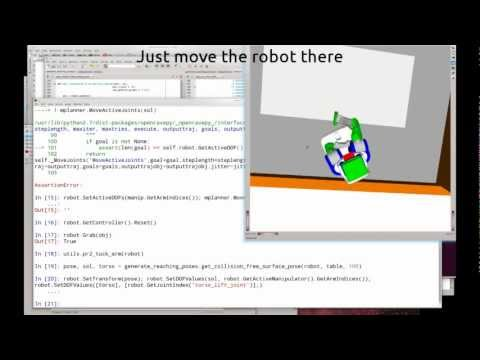

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('o-sQ4nlPmVU', width=853, height=480)

The first thing is to load the environment and the viewer. I am using a standard room provided by the OpenRave distribution.

In [2]:
import openravepy; 
import numpy as np
env = openravepy.Environment()
env.SetViewer('qtcoin')
env.Load('data/pr2test2.env.xml');

Then load my code and select the object to grasp and the surface where to place it.

In [7]:
#%cd ~/src/source_code/src #change this to the folder where you have placed your code.
import generate_reaching_poses
import utils
robot = env.GetRobots()[0]; manip = robot.SetActiveManipulator('rightarm')
obj = env.GetKinBody('TibitsBox1')
table = env.GetKinBody('Table1')

ImportError: No module named trajoptpy.math_utils

It's always a good idea to fold the arms before moving.

In [6]:
utils.pr2_tuck_arm(robot)

Now come the first important part. First thing is to generate grasping positions for the gripper (this can be a long process). Then find a base position from where the gripper pose admits an IK solution, and which is collision free. Then plan a base trajectory to that position and executes it.

In [7]:
pose, sol, torso = generate_reaching_poses.get_collision_free_grasping_pose(robot, obj, 300, use_general_grasps=False)
import navigation; planner = navigation.SimpleNavigationPlanning(robot)
planner.performNavigationPlanning(pose, execute=True)
robot.GetController().Reset()

Once the robot has reached the base pose, lift the torso to the height found above. We are going to use motion planning to move the gripper in position, just to show some nice arm movements.

In [8]:
robot.SetTransform(pose)
robot.SetDOFValues([torso], [robot.GetJointIndex('torso_lift_joint')],)

Here motion plannign kicks in. Give it some time.

In [9]:
mplanner = openravepy.interfaces.BaseManipulation(robot)
robot.SetActiveDOFs(manip.GetArmIndices()); 
mplanner.MoveActiveJoints(sol)
robot.WaitForController(0);

Ok, time to grab the object. We don't deal with real grasping here (the objects are just bounding boxes anyway).

In [10]:
robot.GetController().Reset()
robot.Grab(obj)
utils.pr2_tuck_arm(robot)

We are almost done. The final step is to find a free spot on a table, move there and place the object down. Finding a free spot on a table is very similar to finding a grasping position, but this time instead of checking grasps we check reachability of a random point on a surface. After having found the object we just teleport the robot, we already checked that motion planning works.

In [11]:
pose, sol, torso = generate_reaching_poses.get_collision_free_surface_pose(robot, table, 100)
robot.SetTransform(pose)
robot.SetDOFValues(sol, robot.GetActiveManipulator().GetArmIndices())
robot.SetDOFValues([torso], [robot.GetJointIndex('torso_lift_joint')],)
robot.Release(obj)
utils.pr2_tuck_arm(robot)

That's it! quite crude but effective!